In [201]:
import numpy as np
import pandas as pd

import pylab as plt
import seaborn as sns

from scipy import stats as st
from statsmodels.api import add_constant, OLS

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from statsmodels.api import add_constant, OLS
from statsmodels.formula.api import ols

import pylab as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [202]:
casas=pd.read_csv('D:/UAX/2º Curso/IronHack/Proyecto_Final/regression_data1.csv')
casas.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [203]:
cte_cols = []

for c in casas.select_dtypes(include=np.number): # para columnas de tipo numérico
    
    if casas[c].std()==0:
        cte_cols.append(c)
        
cte_cols
# no hay datos duplicados

[]

In [204]:
casas.info()
#no hay datos nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

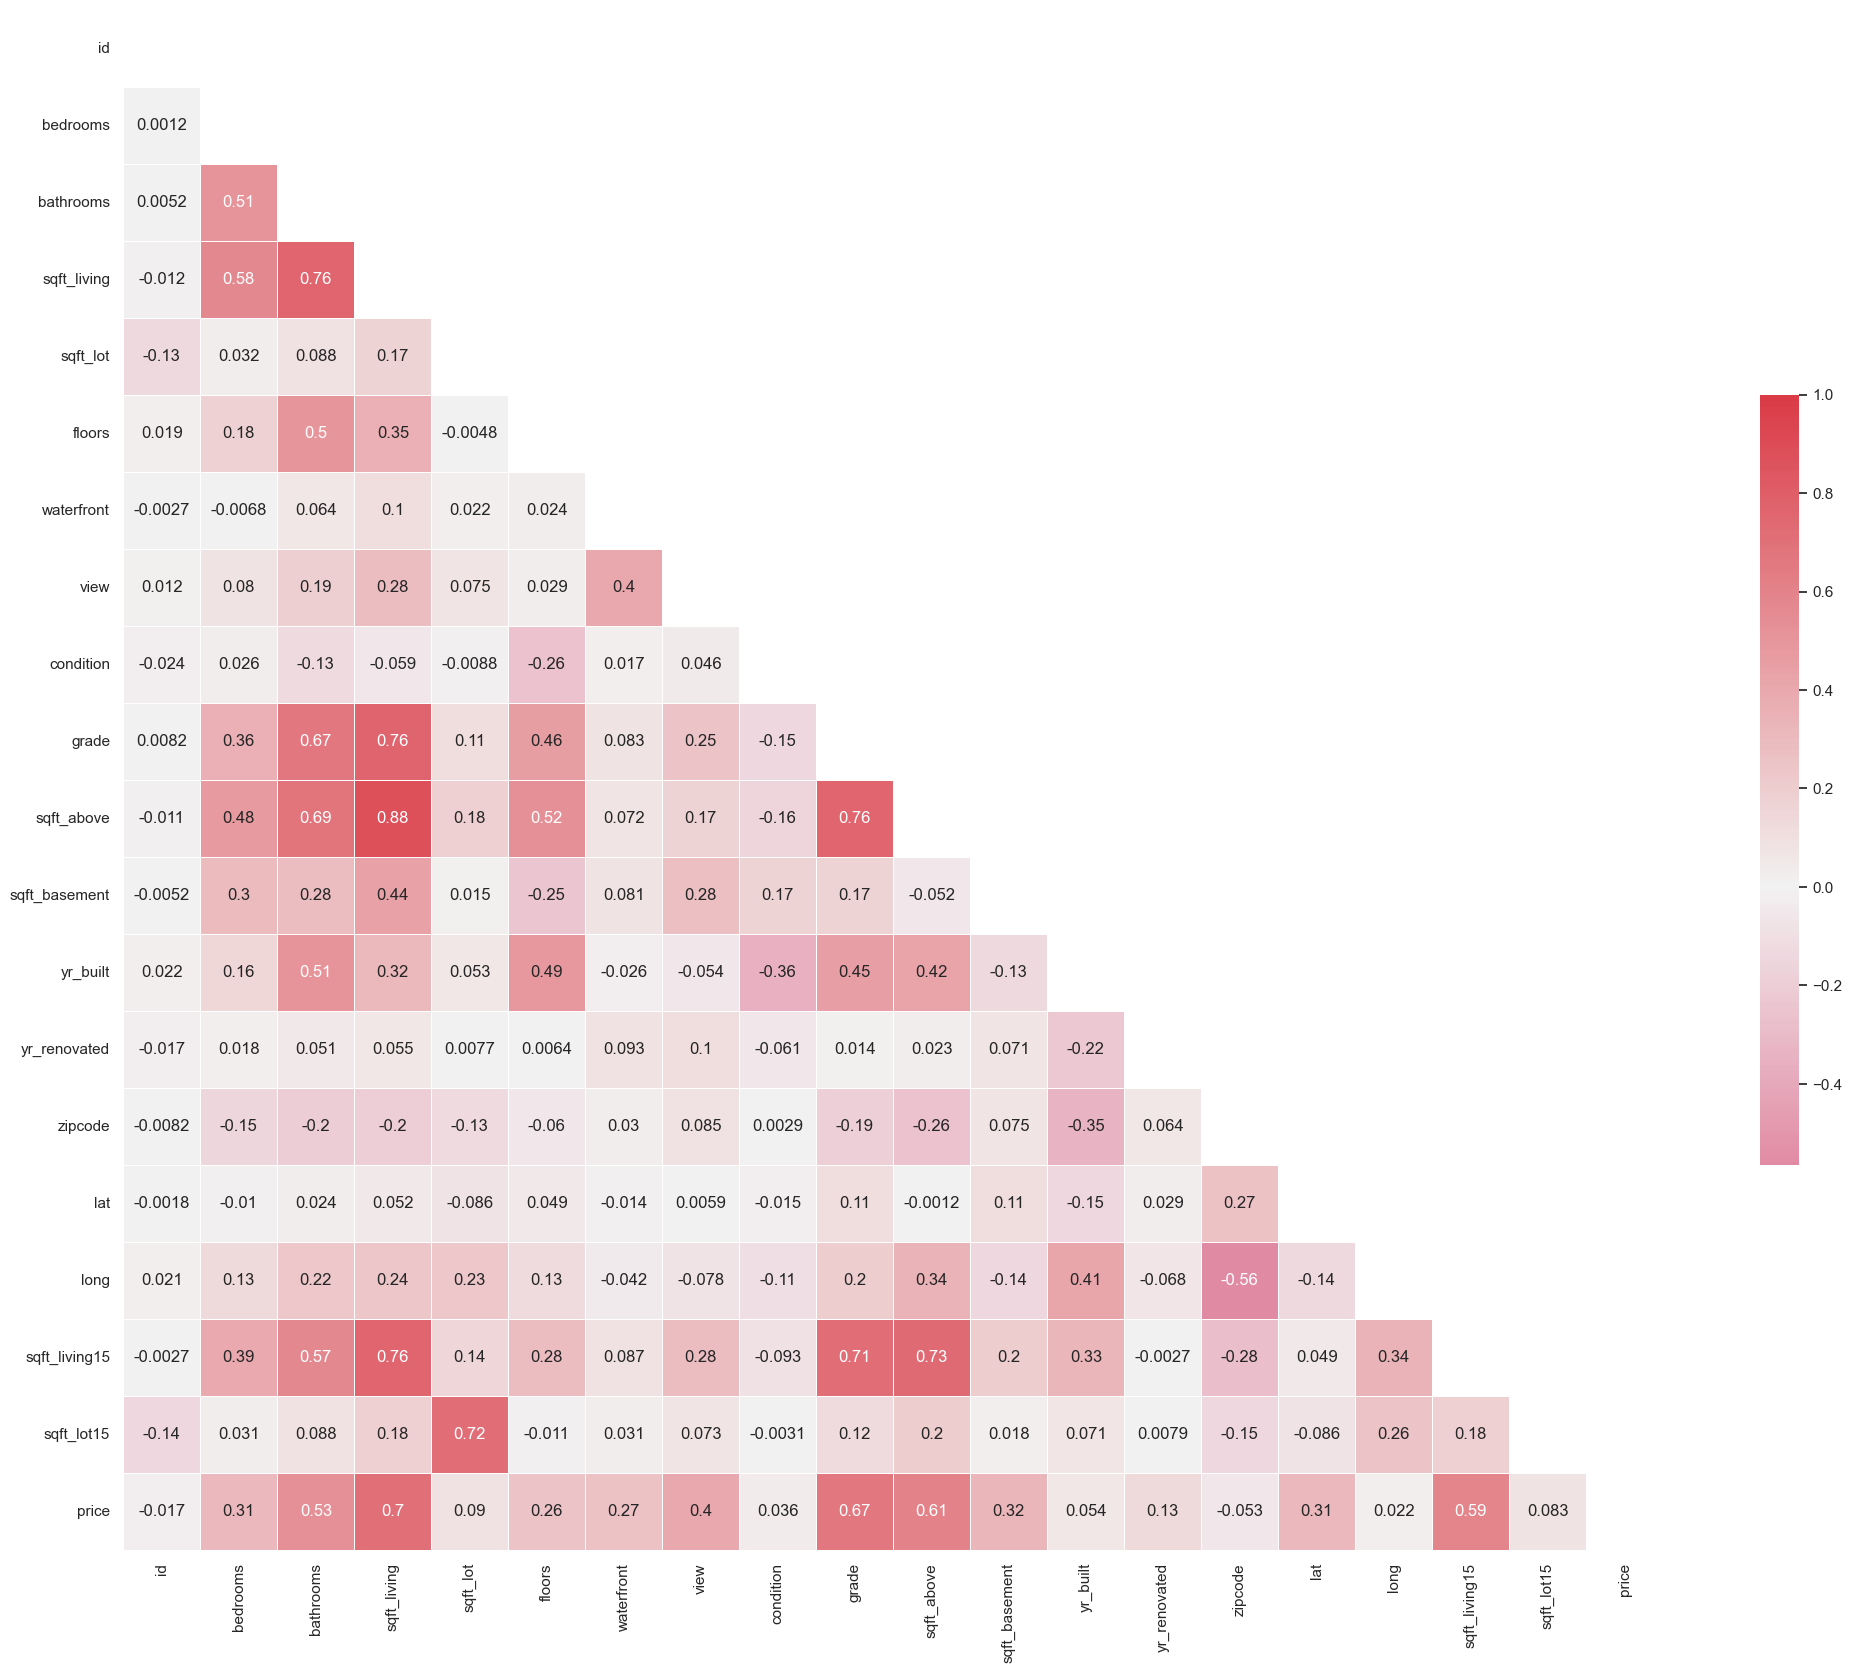

In [205]:
plt.rcParams['figure.figsize']=(25, 20)  # tamaño por defecto para los plots
def print_heatmap_corr(data:pd.DataFrame, annot:bool=True, cmap:str=None, 
                       mask:bool=True, save:bool=False, title:str=None)->None:
    
    '''
        Función que recibe un dataframe y devuelve la matriz de correlación en forma de mapa de color
        
        Parameters:
        -----------
        
        data: Dataset sobre el que queremos realizar la matriz de correlación
        annot: Si queremos mostrar el valor de la correlación en la matriz, default = True
        cmap: Paleta de colores que queremos usar para nuestro heatmap
        mask: Parámetro para mostrar solo la triangular inferior de la matriz de correlación
        save: Parámetro para salvar nuestro gráfico
        title: Título que queremos que lleve nuestro gráfico
    '''
    
    sns.set(style='white')     # estilo blanco hace que el fondo de la matriz sea transparente

    if mask: # Si mask es True
        mascara=np.triu(np.ones_like(data.corr(), dtype=bool))   # genera una mascara para tapar valores
    else:
        mascara = None # No aplicamos máscar

    if cmap: # Si le hemos pasado una paleta de colores
        c_map = sns.color_palette(cmap, as_cmap=True)
    else:
        c_map=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de colores por defecto


    p = sns.heatmap(data.corr(), # aplica el método corr() a nuestro dataset
            mask=mascara, # aplica la mascara
            cmap=c_map, # aplica la paleta de colores
            vmax=1, # para establecer el valor máximo de valores
            center=0, # establece el centro de la paleta de colores
            square=True,
            linewidth=0.5, # para aplicar borde a los cuadros de la matriz
            cbar_kws={'shrink': 0.5}, # mostrar leyenda de colores
            annot=annot # mostrar valores de la matriz
           )
    p.set_title(title, fontsize=20)
    
    if save:
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();
    

print_heatmap_corr(casas)

In [206]:
type( casas.price)

pandas.core.series.Series

In [207]:
#casas.drop("id", axis="columns", inplace=True) #no es relevante porque no aporta informacion acerca del precio
#casas.drop("lat", axis="columns", inplace=True) # no es relevante porque todas las casas estan en la misma zona
#casas.drop("long", axis="columns", inplace=True)#no es relevante porque todas las casas estan en la misma zona
#casas.drop("zipcode", axis="columns", inplace=True) # no es relevante porque todas las casas estan en la misma zona

In [208]:
# creo una columna que calcula los metros cuadrados totales incluyendo sotano, plantas y terreno sea o no  habitable
#casas["sqft_total"]= sum(sum(casas["sqft_lot"] , casas["sqft_above"]) , casas["sqft_basement"])
#casas.drop("sqft_lot", axis="columns", inplace=True)
#casas.drop("sqft_above", axis="columns", inplace=True)
#casas.drop("sqft_basement", axis="columns", inplace=True)

In [209]:
# creo una nueva columna last renovation, que junta las columnas year_built y year_renovated
#casas["last_renovation"] = casas[["yr_built","yr_renovated"]].max(axis=1)
#casas.drop("yr_built", axis="columns", inplace=True)
#casas.drop("yr_renovated", axis="columns", inplace=True)

In [210]:
#casas.drop("bedrooms", axis="columns", inplace=True) # esta información es no es util sabiendo los metros cuadrados
#casas.drop("bathrooms", axis="columns", inplace=True) # esta informacion no es util sabiendo los metros cuadrados
#casas.drop("condition", axis="columns", inplace=True) #condition no es utill sabiendo el grade
#casas.drop("floors", axis="columns", inplace=True) # esta informacion no es util sabiendo los metros cuadrados
#casas.drop("waterfront", axis="columns", inplace=True) #esta informacion no es util pues el precio es equivalente con o sin waterfront
#casas.drop("sqft_lot15", axis="columns", inplace=True)

In [211]:

def remove_outliers_from_dataframe(df, col, threshold: float = 3):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    intraquartile_range = q3 - q1
    fence_low  = q1 - threshold * intraquartile_range
    fence_high = q3 + threshold * intraquartile_range
    return df.loc[(df[col] > fence_low) & (df[col] < fence_high)]


casas=remove_outliers_from_dataframe(casas, "sqft_living")

casas.info()
#casas.drop("sqft_total", axis="columns", inplace=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21523 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21523 non-null  int64  
 1   date           21523 non-null  object 
 2   bedrooms       21523 non-null  int64  
 3   bathrooms      21523 non-null  float64
 4   sqft_living    21523 non-null  int64  
 5   sqft_lot       21523 non-null  int64  
 6   floors         21523 non-null  float64
 7   waterfront     21523 non-null  int64  
 8   view           21523 non-null  int64  
 9   condition      21523 non-null  int64  
 10  grade          21523 non-null  int64  
 11  sqft_above     21523 non-null  int64  
 12  sqft_basement  21523 non-null  int64  
 13  yr_built       21523 non-null  int64  
 14  yr_renovated   21523 non-null  int64  
 15  zipcode        21523 non-null  int64  
 16  lat            21523 non-null  float64
 17  long           21523 non-null  float64
 18  sqft_l

In [212]:
#casas.drop("last_renovation", axis="columns", inplace=True)
#casas.drop("sqft_total", axis="columns", inplace=True)
#casas.drop("view", axis="columns", inplace=True)
#asas.drop("sqft_living", axis="columns", inplace=True)

In [213]:
#reordeno las columnas para que price esté al final
precio = casas['price'] 
n= len(casas.columns)
casas.drop(labels=['price'], axis="columns",inplace = True)
casas.insert(n-1, 'price', precio)


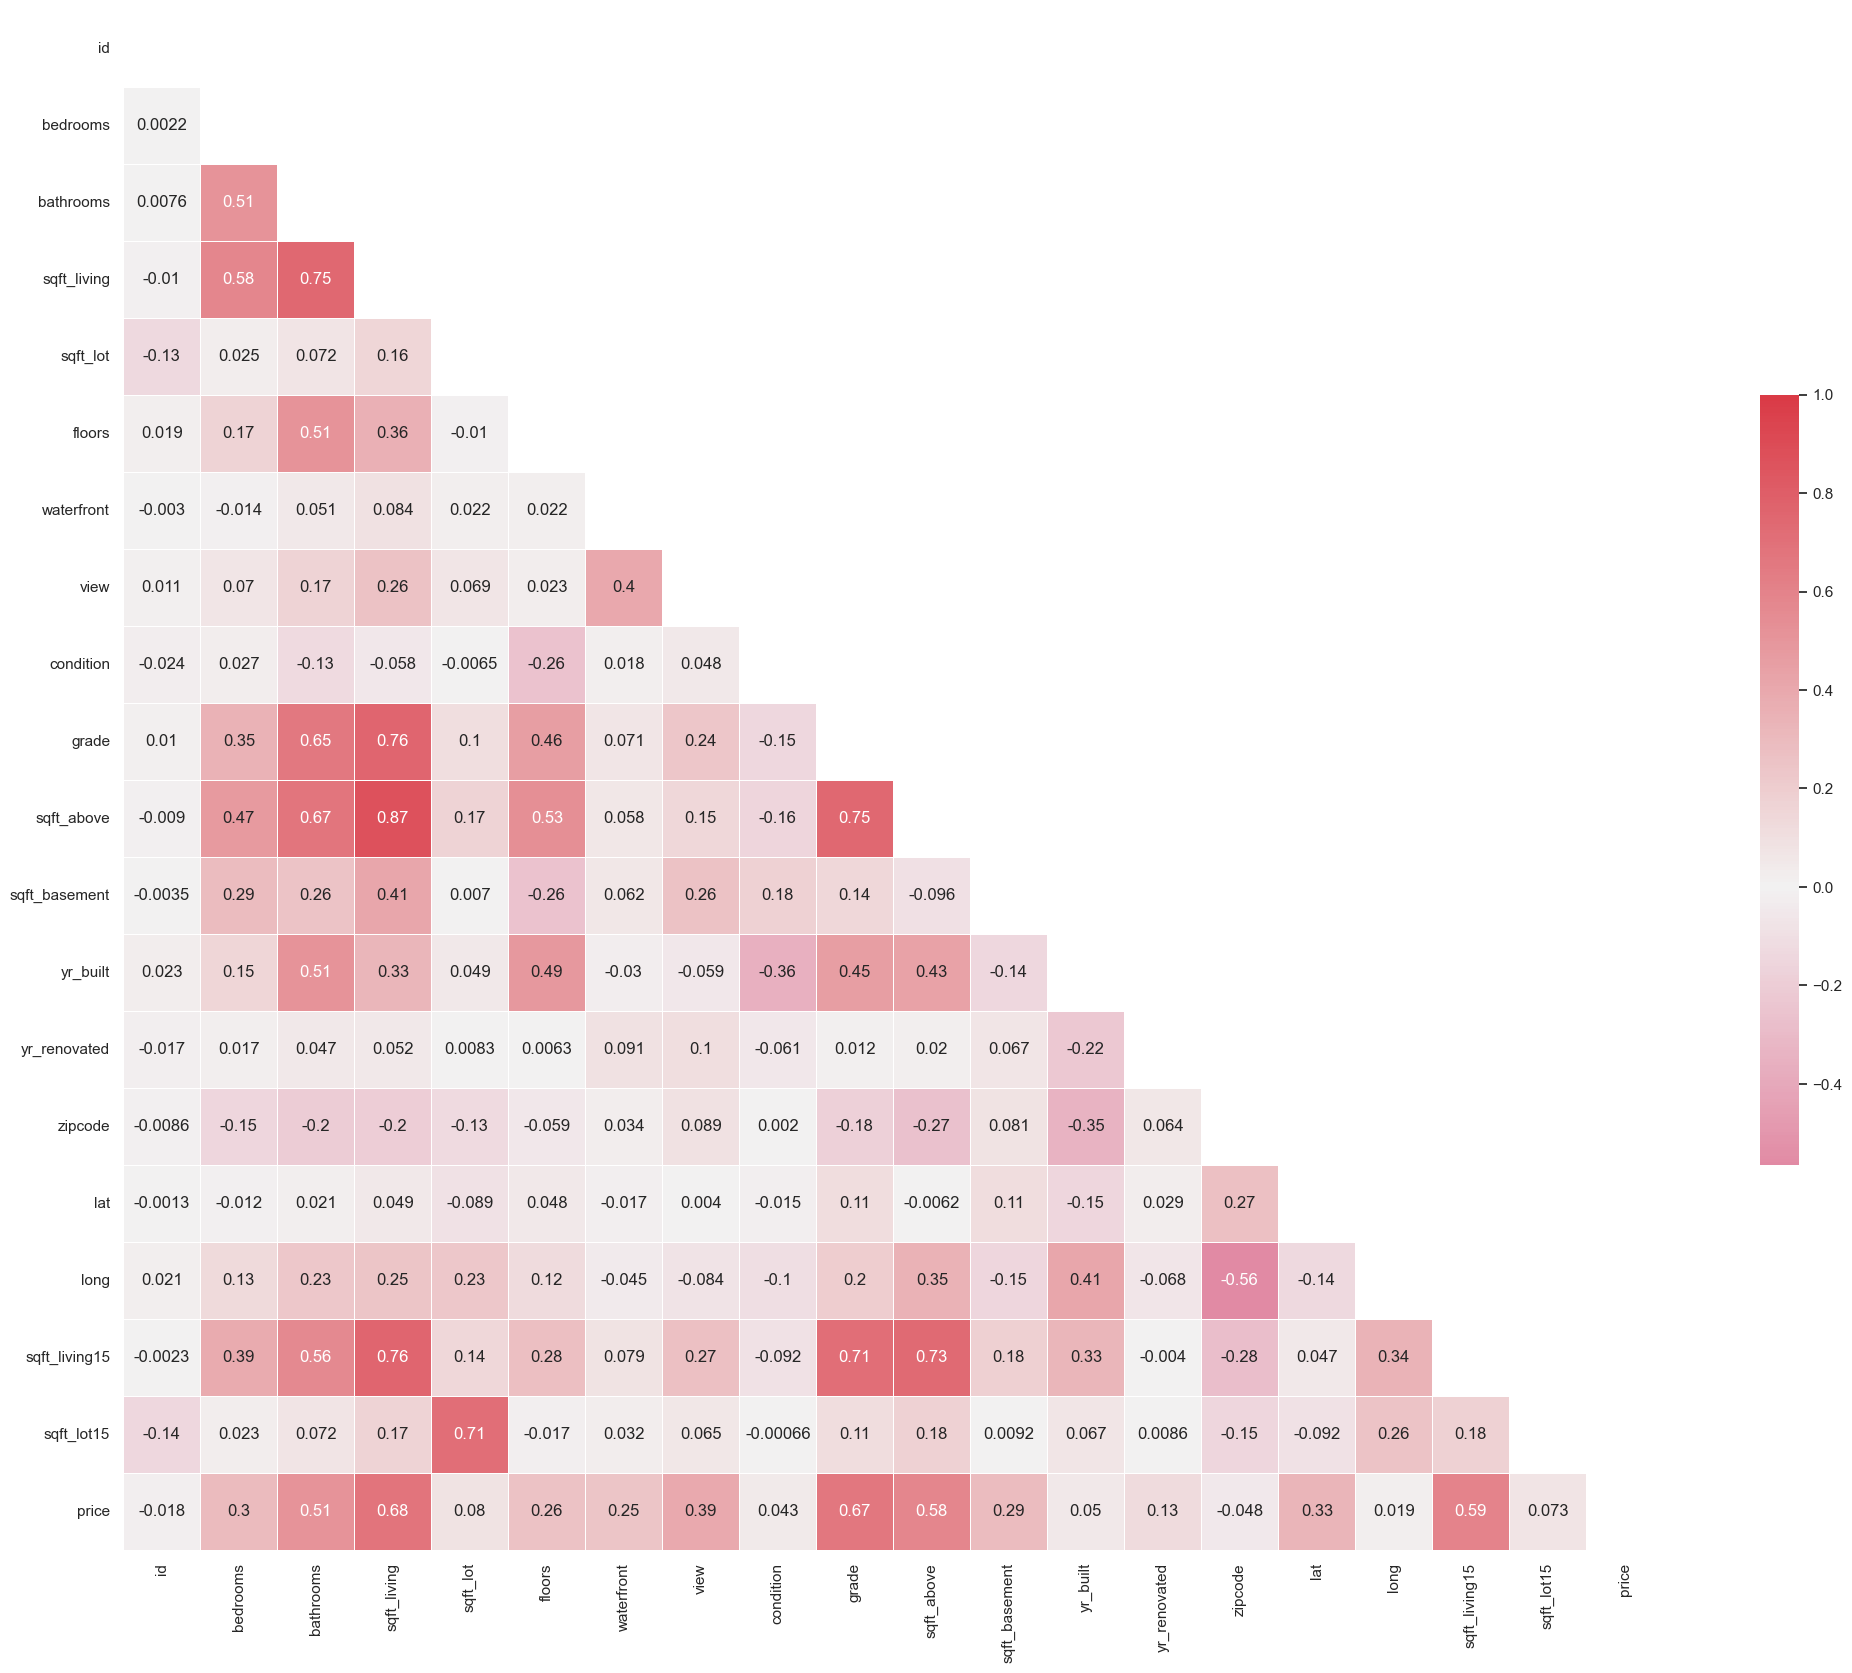

In [214]:
print_heatmap_corr(casas)

In [215]:
casas.corr()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
id,1.000000,0.002221,0.007639,-0.009962,-0.131427,0.019105,-0.003024,0.011028,-0.023959,0.010228,-0.008986,-0.003469,0.022566,-0.016951,-0.008646,-0.001277,0.021254,-0.002266,-0.141092,-0.018312
bedrooms,0.002221,1.000000,0.508174,0.581507,0.025299,0.172850,-0.013548,0.070122,0.027489,0.346761,0.474835,0.293834,0.154464,0.017095,-0.153239,-0.011610,0.130542,0.386684,0.023443,0.302808
bathrooms,0.007639,0.508174,1.000000,0.745239,0.071518,0.505511,0.051108,0.170434,-0.126555,0.654204,0.672407,0.259182,0.514169,0.047447,-0.204993,0.021313,0.225113,0.561948,0.071661,0.506343
sqft_living,-0.009962,0.581507,0.745239,1.000000,0.156596,0.356183,0.083702,0.263806,-0.057890,0.756319,0.868201,0.410394,0.326447,0.051739,-0.202687,0.049279,0.245552,0.761285,0.169772,0.678610
sqft_lot,-0.131427,0.025299,0.071518,0.156596,1.000000,-0.009972,0.021923,0.068528,-0.006476,0.102754,0.167141,0.006957,0.048879,0.008283,-0.128981,-0.088985,0.226855,0.139853,0.710291,0.080198
floors,0.019105,0.172850,0.505511,0.356183,-0.009972,1.000000,0.021664,0.023240,-0.264502,0.458153,0.530472,-0.260394,0.490232,0.006289,-0.058550,0.048239,0.124770,0.276923,-0.017229,0.261023
waterfront,-0.003024,-0.013548,0.051108,0.083702,0.021923,0.021664,1.000000,0.397012,0.017613,0.071159,0.057849,0.061588,-0.029799,0.091430,0.034261,-0.016680,-0.044659,0.079326,0.032182,0.245997
view,0.011028,0.070122,0.170434,0.263806,0.068528,0.023240,0.397012,1.000000,0.047744,0.237037,0.146014,0.260840,-0.059108,0.103728,0.089187,0.003987,-0.083729,0.270276,0.065054,0.391486
condition,-0.023959,0.027489,-0.126555,-0.057890,-0.006476,-0.264502,0.017613,0.047744,1.000000,-0.147000,-0.160499,0.178831,-0.360883,-0.061068,0.002045,-0.014970,-0.104856,-0.092467,-0.000655,0.043030
grade,0.010228,0.346761,0.654204,0.756319,0.102754,0.458153,0.071159,0.237037,-0.147000,1.000000,0.747609,0.143206,0.451050,0.011565,-0.184451,0.112642,0.198861,0.709311,0.111068,0.668824


In [216]:
X= casas.drop(["price","date"], axis="columns") 
y= casas["price"]

In [217]:
def plot_regression_model(x,y):
    
    x_const = add_constant(x) # add a constant to the model
    
    modelo = OLS(y, x_const).fit() # fit the model
    
    pred = modelo.predict(x_const) # make predictions
    
    print(modelo.summary());
    try:
        const = modelo.params[0] # create a variable with the value of the constant given by the summary
        coef = modelo.params[1] # create a variable with the value of the coef given by the summary

        x_l=np.linspace(x.min(), x.max(), 50) 
        y_l= coef*x_l + const # function of the line

        plt.figure(figsize=(10, 10));

        # plot the line
        plt.plot(x_l, y_l, label=f'{x.name} vs {y.name}={coef}*{x.name}+{const}');

        # data
        plt.scatter(x, y, marker='x', c='g', label=f'{x.name} vs {y.name}');

        plt.title('Regresion lineal')
        plt.xlabel(f'{x.name}')
        plt.ylabel(f'{y.name}')
        plt.legend()
        plt.show();
        return modelo
    except:
        print('No se puede imprimir la recta de regresión para modelos multivariable')
        plt.show();
        return modelo



In [218]:
"""
for c in X:
    plot_regression_model(X[c], y)

"""

'\nfor c in X:\n    plot_regression_model(X[c], y)\n\n'

In [219]:
multi = plot_regression_model(X,y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     2769.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:32:05   Log-Likelihood:            -2.9155e+05
No. Observations:               21523   AIC:                         5.831e+05
Df Residuals:                   21504   BIC:                         5.833e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.062e+06    2.7e+06      1.503

<Figure size 1000x1000 with 0 Axes>

In [220]:
ln= LinearRegression()
ln.fit(X,y)





LinearRegression()

In [221]:
X_train ,X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.1)

In [222]:


X_train.shape, X_test.shape, y_train.shape, y_test.shape


((19370, 19), (2153, 19), (19370,), (2153,))

In [223]:


sc = StandardScaler().fit(X_train)



In [224]:

X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)


X_train.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
11172,104530240,3,2.00,1320,5665,1.0,0,0,3,7,1320,0,1986,0,98023,47.3096,-122.357,1336,7080
17167,3818700185,4,1.50,2150,11026,1.0,0,0,4,7,2150,0,1952,0,98028,47.7635,-122.263,1760,10283
6688,3331001995,3,2.00,1440,4859,2.0,0,0,2,6,1440,0,1921,0,98118,47.5503,-122.285,1360,4558
11294,7175300045,3,1.75,1480,4050,1.0,0,0,3,7,870,610,1926,0,98115,47.6810,-122.304,1350,4500
12313,6795100563,4,2.50,1820,20011,2.0,0,0,3,8,1820,0,1987,0,98075,47.5842,-122.045,2710,33915


In [225]:
X_train_sc

array([[-1.55841524e+00, -3.98392695e-01, -1.37873319e-01, ...,
        -1.01352804e+00, -9.53142799e-01, -2.07748928e-01],
       [-2.67882840e-01,  6.84068591e-01, -8.05274591e-01, ...,
        -3.43554396e-01, -3.24827323e-01, -8.78516029e-02],
       [-4.37339361e-01, -3.98392695e-01, -1.37873319e-01, ...,
        -5.00356738e-01, -9.17577772e-01, -3.02154501e-01],
       ...,
       [ 1.77807865e-01,  6.84068591e-01,  5.29527953e-01, ...,
        -6.64286459e-01, -2.84520981e-02, -2.01385348e-01],
       [-9.21597557e-01, -3.98392695e-01,  1.86433050e+00, ...,
        -6.57159080e-01,  1.18542439e-03, -3.52988272e-01],
       [ 6.05393010e-01, -3.98392695e-01, -1.37873319e-01, ...,
        -1.17033038e+00, -7.99027682e-01, -2.27588322e-01]])

In [226]:

linreg=LinearRegression()
lasso=Lasso() # Favorece si nuestras betas son próximas a 0 L1
ridge=Ridge() # Favorece cuando hay sospechas de correlación entre caracteristicas L2
elastic=ElasticNet() # Mezcla de las anteriores, funciona bien cuando hay muchas características (L1+L2)


In [227]:

linreg.fit(X_train_sc, y_train)
lasso.fit(X_train_sc, y_train)
ridge.fit(X_train_sc, y_train)
elastic.fit(X_train_sc, y_train)


ElasticNet()

In [228]:
y.describe()

count    2.152300e+04
mean     5.332883e+05
std      3.366879e+05
min      7.800000e+04
25%      3.210000e+05
50%      4.500000e+05
75%      6.400000e+05
max      3.850000e+06
Name: price, dtype: float64

In [229]:
from sklearn.metrics import mean_squared_error as mse

print(f' MSE linreg en train: {mse(y_train, linreg.predict(X_train_sc))}\n')
print(f' MSE linreg en test: {mse(y_test, linreg.predict(X_test_sc))}\n')
print(f' MSE lasso en train: {mse(y_train, lasso.predict(X_train_sc))}\n')
print(f' MSE lasso en test: {mse(y_test, lasso.predict(X_test_sc))}\n')
print(f' MSE ridge en train: {mse(y_train, ridge.predict(X_train_sc))}\n')
print(f' MSE ridge en test: {mse(y_test, ridge.predict(X_test_sc))}\n')
print(f' MSE ElasticNet en train: {mse(y_train, elastic.predict(X_train_sc))}\n')
print(f' MSE ElasticNet en test: {mse(y_test, elastic.predict(X_test_sc))}\n')

 MSE linreg en train: 33869442352.49125

 MSE linreg en test: 36900795459.00116

 MSE lasso en train: 33869442394.55598

 MSE lasso en test: 36900787192.59681

 MSE ridge en train: 33869442498.751232

 MSE ridge en test: 36900832273.177826

 MSE ElasticNet en train: 37515774331.00714

 MSE ElasticNet en test: 41548205559.94992



In [230]:
print(f' RMSE linreg en train: {mse(y_train, linreg.predict(X_train_sc), squared=False)}\n')
print(f' RMSE linreg en test: {mse(y_test, linreg.predict(X_test_sc), squared=False)}\n')
print(f' RMSE lasso en train: {mse(y_train, lasso.predict(X_train_sc), squared=False)}\n')
print(f' RMSE lasso en test: {mse(y_test, lasso.predict(X_test_sc), squared=False)}\n')
print(f' RMSE ridge en train: {mse(y_train, ridge.predict(X_train_sc), squared=False)}\n')
print(f' RMSE ridge en test: {mse(y_test, ridge.predict(X_test_sc), squared=False)}\n')
print(f' RMSE ElasticNet en train: {mse(y_train, elastic.predict(X_train_sc), squared=False)}\n')
print(f' RMSE ElasticNet en test: {mse(y_test, elastic.predict(X_test_sc), squared=False)}\n')

 RMSE linreg en train: 184036.52450666213

 RMSE linreg en test: 192095.7976089044

 RMSE lasso en train: 184036.52462094577

 RMSE lasso en test: 192095.77609254402

 RMSE ridge en train: 184036.52490402886

 RMSE ridge en test: 192095.893431322

 RMSE ElasticNet en train: 193689.8921756299

 RMSE ElasticNet en test: 203833.76942977315



In [231]:


from sklearn.metrics import mean_absolute_error as mae

print(f' MAE linreg en train: {mae(y_train, linreg.predict(X_train_sc))}\n')
print(f' MAE linreg en test: {mae(y_test, linreg.predict(X_test_sc))}\n')
print(f' MAE lasso en train: {mae(y_train, lasso.predict(X_train_sc))}\n')
print(f' MAE lasso en test: {mae(y_test, lasso.predict(X_test_sc))}\n')
print(f' MAE ridge en train: {mae(y_train, ridge.predict(X_train_sc))}\n')
print(f' MAE ridge en test: {mae(y_test, ridge.predict(X_test_sc))}\n')
print(f' MAE ElasticNet en train: {mae(y_train, elastic.predict(X_train_sc))}\n')
print(f' MAE ElasticNet en test: {mae(y_test, elastic.predict(X_test_sc))}\n')


 MAE linreg en train: 119632.18112528724

 MAE linreg en test: 121629.37151343735

 MAE lasso en train: 119632.00725504696

 MAE lasso en test: 121629.21145723213

 MAE ridge en train: 119630.61609376369

 MAE ridge en test: 121627.57993666061

 MAE ElasticNet en train: 120042.06035689209

 MAE ElasticNet en test: 122069.84989520394



In [232]:


print(f' R2 linreg en train: {linreg.score(X_train_sc, y_train)}\n')
print(f' R2 linreg en test: {linreg.score(X_test_sc, y_test)}\n')
print(f' R2 lasso en train: {lasso.score(X_train_sc, y_train)}\n')
print(f' R2 lasso en test: {lasso.score(X_test_sc, y_test)}\n')
print(f' R2 ridge en train: {ridge.score(X_train_sc, y_train)}\n')
print(f' R2 ridge en test: {ridge.score(X_test_sc, y_test)}\n')
print(f' R2 ElasticNet en train: {elastic.score(X_train_sc, y_train)}\n')
print(f' R2 ElasticNet en test: {elastic.score(X_test_sc, y_test)}\n')



 R2 linreg en train: 0.6964535882293723

 R2 linreg en test: 0.7145778301688138

 R2 lasso en train: 0.6964535878523777

 R2 lasso en test: 0.7145778941082231

 R2 ridge en train: 0.6964535869185537

 R2 ridge en test: 0.7145775454166274

 R2 ElasticNet en train: 0.66377424923454

 R2 ElasticNet en test: 0.6786308035909734

